# Topic 10 — Rule-Based EMS (Baseline Controller)

This notebook demonstrates a transparent, heuristic Energy Management System (EMS).
It **does not** use forecasting or beliefs. We run **three independent scenarios**:

1. **Sunny Day, Grid Connected** — normal operation.
2. **Midday Islanding** — grid is disconnected for a few hours (islanded microgrid).
3. **Expensive Grid Imports** — higher grid import tariff to stress local generation & storage.

For each scenario, we build the microgrid, run the EMS-driven simulation,
and plot conference-quality figures using the project's standard utilities.


In [1]:
import sys, os, importlib
import numpy as np
import pandas as pd

# --- Path setup so we can `import microgrid_sim` from the repo root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Using project_root:", project_root)

Using project_root: c:\Users\olanr\Downloads\course-proj\microgrid-control-sim


In [2]:
from microgrid_sim.core import MicrogridEnv
from microgrid_sim.components.generators import PVGenerator, WindTurbine, FossilGenerator, GridIntertie
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
from microgrid_sim.control import RuleBasedEMS, EMSRuleParams
from microgrid_sim.utils import plot_simulation, DataSeries, ExogenousSpec, ExogenousBuilder

# Reload modules for iterative development in notebooks
importlib.reload(sys.modules['microgrid_sim.core'])
importlib.reload(sys.modules['microgrid_sim.control'])
importlib.reload(sys.modules['microgrid_sim.utils'])

print("Imports OK")

Imports OK


## General Constants

In [ ]:
steps = 24 * 1
dt = 60

rng = np.random.RandomState(seed=1)

## Data Generation (Using DataSeries and ExogenousBuilder)

In [ ]:
# Diurnal profile shapes
res_shape = np.array([
    0.6, 0.55, 0.5, 0.5, 0.55, 0.8, 1.0, 0.9, 0.8,
    0.7, 0.65, 0.6, 0.65, 0.8, 1.0, 1.2, 1.4, 1.2,
    1.0, 0.9, 0.8, 0.7, 0.65, 0.6
])
fac_shape = np.array([
    0.2, 0.2, 0.2, 0.3, 0.5, 0.8, 1.0, 1.1, 1.1,
    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8,
    0.6, 0.5, 0.4, 0.3, 0.2, 0.2
])

# Generate time-series arrays for 24 steps
t_hours = np.arange(steps) % 24
pv_clear = np.maximum(0, np.sin((t_hours - 6) * np.pi / 12.0))

ghi_array = np.maximum(0, 900 * pv_clear * (1.0 + 0.05 * rng.randn(steps)))
wind_array = np.maximum(0, (6.0 + 2.0 * np.sin(t_hours * 2*np.pi/24 + 0.5)) * (1.0 + 0.1 * rng.randn(steps)))
fac_array = np.maximum(0, 10.0 * fac_shape[t_hours] * (1.0 + 0.05 * rng.randn(steps)))
res1_array = np.maximum(0, 1.5 * res_shape[t_hours] * (1.0 + 0.1 * rng.randn(steps)))
res2_array = np.maximum(0, 1.2 * res_shape[t_hours] * (1.0 + 0.1 * rng.randn(steps)))
res3_array = np.maximum(0, 1.8 * res_shape[t_hours] * (1.0 + 0.1 * rng.randn(steps)))

# Wrap arrays in DataSeries
ghi_ds = DataSeries.from_array(ghi_array, name="ghi_Wm2")
wind_ds = DataSeries.from_array(wind_array, name="wind_ms")
fac_ds = DataSeries.from_array(fac_array, name="factory_kw")
res1_ds = DataSeries.from_array(res1_array, name="house1_kw")
res2_ds = DataSeries.from_array(res2_array, name="house2_kw")
res3_ds = DataSeries.from_array(res3_array, name="house3_kw")

# Define the Specification
spec = ExogenousSpec({
    "pv":       {"irradiance_Wm2": ghi_ds},
    "wind":     {"wind_speed_ms": wind_ds},
    "factory":  {"load_kw": fac_ds},
    "house1":   {"load_kw": res1_ds},
    "house2":   {"load_kw": res2_ds},
    "house3":   {"load_kw": res3_ds},
})

# Build the final exog_list
builder = ExogenousBuilder(spec)
exog_list = builder.build(steps=steps, start_index=0)

print(f"Correctly built exogenous list for {len(exog_list)} steps using ExogenousBuilder.")
print("Example data for step 0:")
print(exog_list[0])


Correctly built exogenous list for 24 steps using ExogenousBuilder.
Example data for step 0:
{'pv': {'irradiance_Wm2': 0.0}, 'wind': {'wind_speed_ms': 7.5857433165032315}, 'factory': {'load_kw': 2.012015895248163}, 'house1': {'load_kw': 0.9144033362503048}, 'house2': {'load_kw': 0.6952425353588826}, 'house3': {'load_kw': 1.077341368765416}}


## Scenario 1 — Sunny Day, Grid Connected

Running Scenario 1: Sunny Day (Grid Connected)...
Scenario 1 Total Cost: $-44.17
Scenario 1 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,wind_power,wind_cost,diesel_power,diesel_cost,grid_power,grid_cost,bat_power,bat_cost,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step,,,,,,,,,,,,,,,,,,,,,
19,0.0,0.0,0.137628,0.0,0.0,0.0,3.183139,-0.636628,6.0,-0.06,...,0.137628,-9.320768,6.0,3.183139,-3.183139,0.0,0.0,0.0,-0.696628,19.0
20,0.0,0.0,0.085780,0.0,4.0,-1.0,-2.124280,0.106214,6.0,-0.06,...,4.085780,-7.961500,6.0,-2.124280,2.124280,0.0,0.0,0.0,-0.953786,20.0
21,0.0,0.0,0.100270,0.0,4.0,-1.0,-4.375356,0.218768,6.0,-0.06,...,4.100270,-5.724914,6.0,-4.375356,4.375356,0.0,0.0,0.0,-0.841232,21.0
22,0.0,0.0,0.316426,0.0,4.0,-1.0,0.694583,-0.138917,0.0,-0.00,...,4.316426,-5.011010,0.0,0.694583,-0.694583,0.0,0.0,0.0,-1.138917,22.0
23,0.0,0.0,1.237430,0.0,4.0,-1.0,-0.470431,0.023522,0.0,-0.00,...,5.237430,-4.766999,0.0,-0.470431,0.470431,0.0,0.0,0.0,-0.976478,23.0


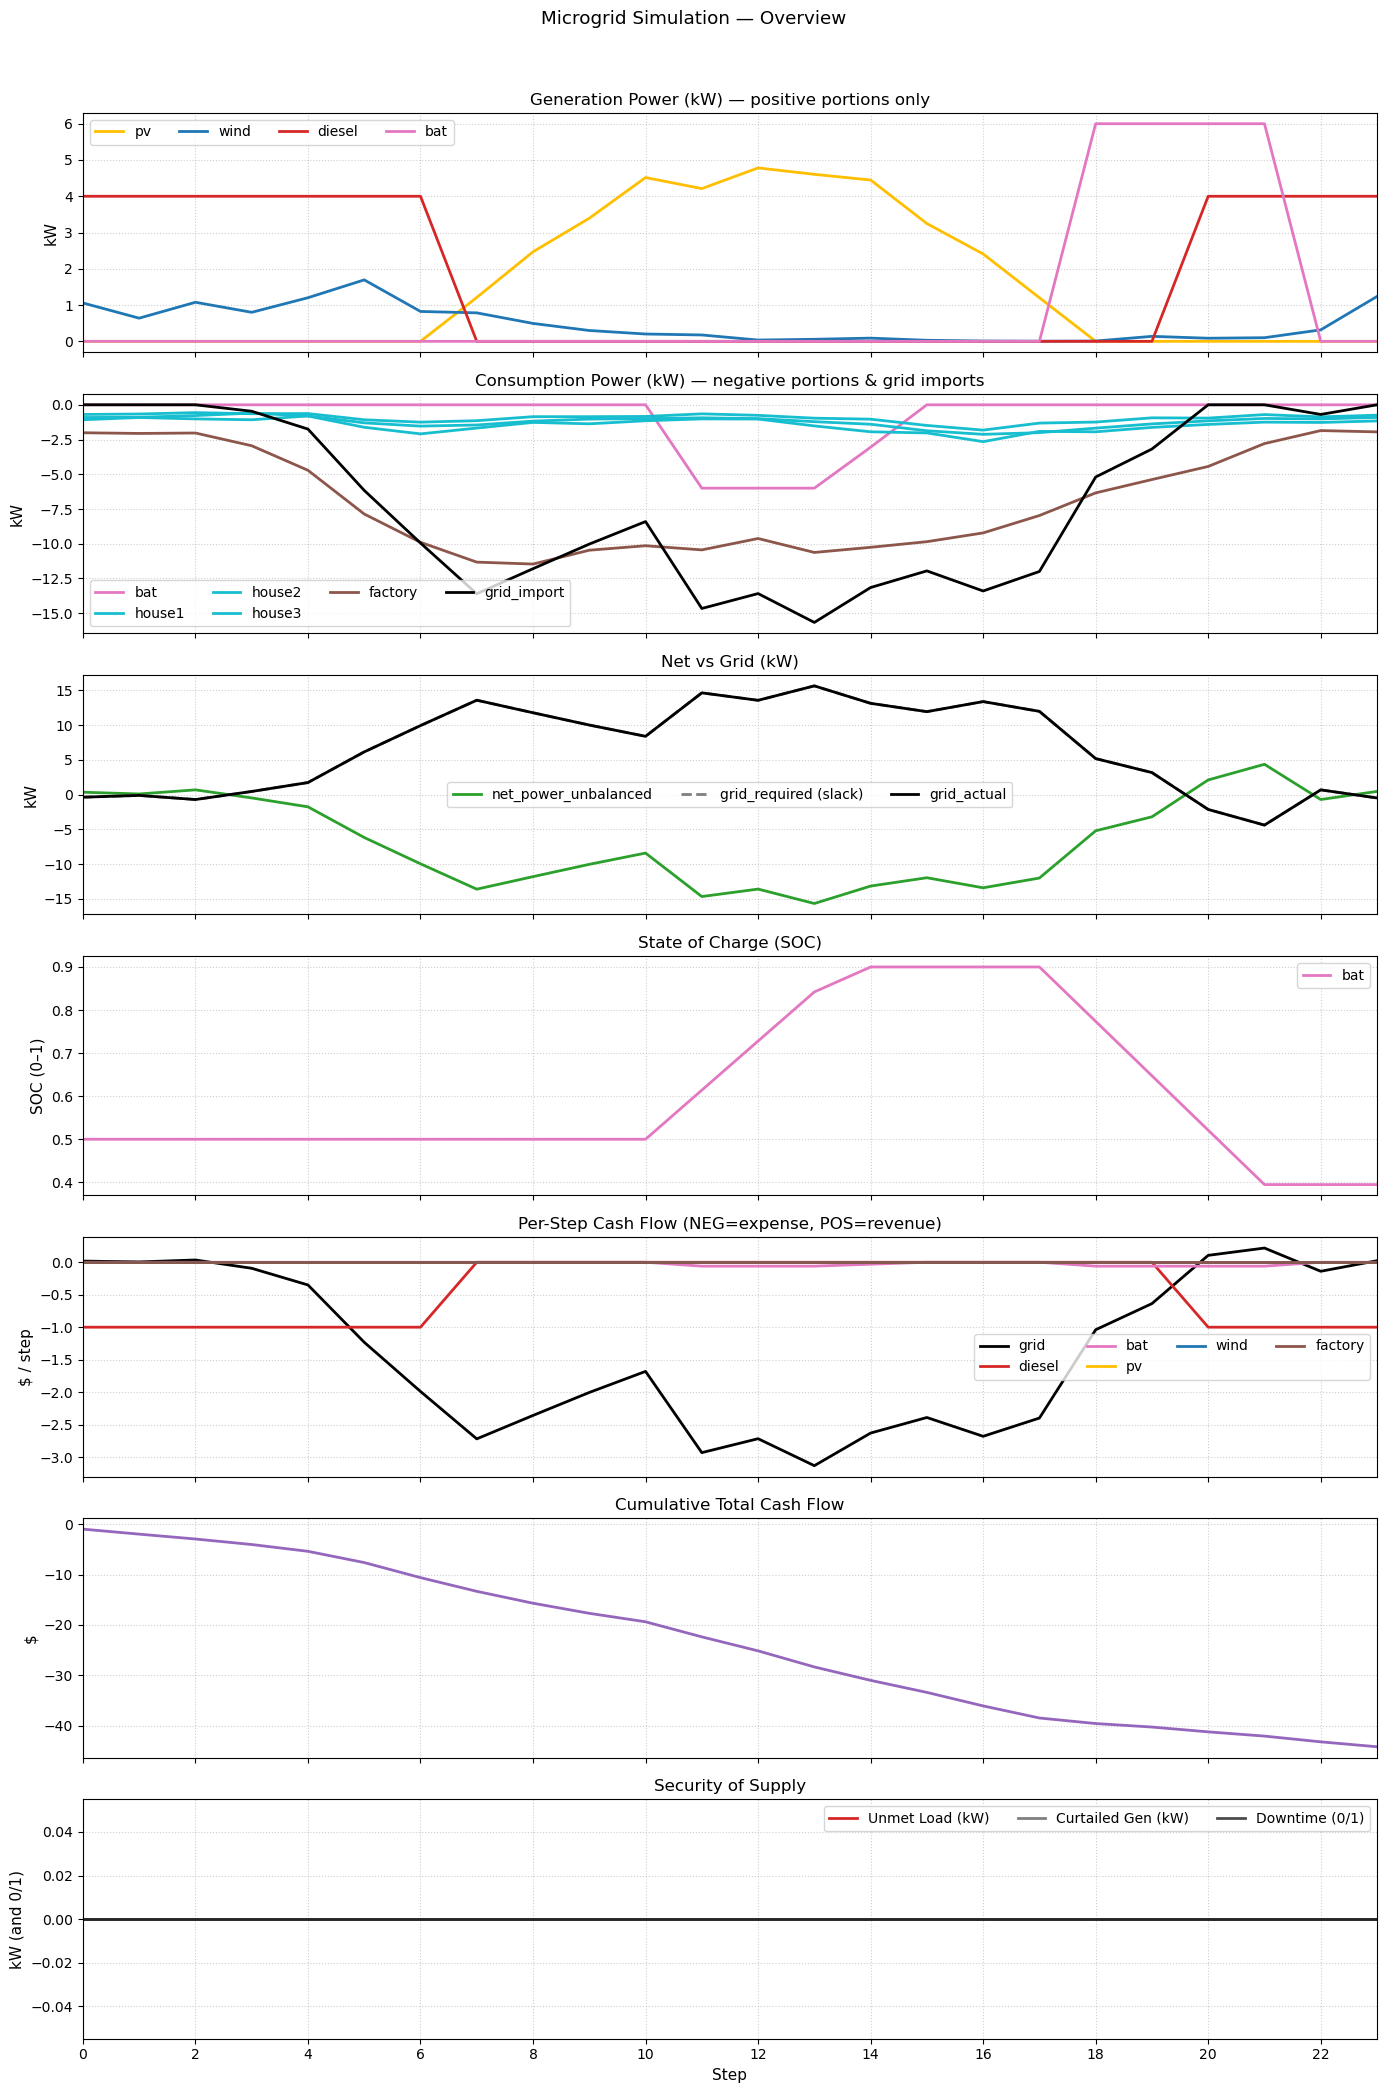

In [ ]:
# --- 1. Define Components ---
pv = PVGenerator("pv", capacity_kw=6.0, time_step_minutes=dt, derate=0.9)
wind = WindTurbine("wind", rated_kw=8.0, time_step_minutes=dt)
diesel = FossilGenerator("diesel", p_min_kw=0.0, p_max_kw=15.0, time_step_minutes=dt, fuel_cost_per_kwh=0.25)

# FIX: Use unique names for each component
house1 = ResidentialLoad("house1", base_kw=1.5, noise_std=0.1)
house2 = ResidentialLoad("house2", base_kw=1.2, noise_std=0.1)
house3 = ResidentialLoad("house3", base_kw=1.8, noise_std=0.1)
factory = FactoryLoad("factory", base_kw=10.0, noise_std=0.1)

bat = BatteryStorage(
    "bat", capacity_kwh=50.0, time_step_minutes=dt, initial_soc=0.5,
    min_soc=0.1, max_soc=0.9, max_charge_kw=8.0, max_discharge_kw=8.0,
    charge_efficiency=0.95, discharge_efficiency=0.95, degradation_cost_per_kwh=0.01
)
grid = GridIntertie("grid", time_step_minutes=dt, price_import_per_kwh=0.20, price_export_per_kwh=0.05)

# --- 2. Build Environment ---
env1 = MicrogridEnv(simulation_steps=steps)
for c in (pv, wind, diesel, house1, house2, house3, factory, bat):
    env1.add_component(c)
env1.add_component(grid, is_grid=True)
env1.reset()

# --- 3. Define Controller ---
ems = RuleBasedEMS()

# --- 4. Run Online Simulation Loop ---
print("Running Scenario 1: Sunny Day (Grid Connected)...")
for k in range(steps):
    hour = k % 24
    soc = bat.get_soc()

    # Get external data for this step
    current_exog = exog_list[k]

    # EMS decides actions based on current state
    actions = ems.decide(hour=hour, soc=soc, exogenous=current_exog)

    # Environment steps forward
    env1.step(actions=actions, exogenous=current_exog)

# --- 5. Get Results and Plot ---
df1 = env1.get_results()
_ = plot_simulation(df1, actions=None, sim_name="03-01_rule_based_sunny", save=True)

# --- 6. Summary ---
dt_hours = dt / 60.0
total_cost_1 = df1["total_cashflow"].sum()
unmet_energy_1 = df1["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 1 Total Cost: ${total_cost_1:.2f}")
print(f"Scenario 1 Unmet Energy (kWh): {unmet_energy_1:.2f}")
df1.tail()

## Scenario 2 — Midday Islanding


Running Scenario 2: Midday Islanding (hours 10-15)...
Scenario 2 Total Cost: $-31.08
Scenario 2 Unmet Energy (kWh): 65.46


,pv_power,pv_cost,wind_power,wind_cost,diesel_power,diesel_cost,grid_power,grid_cost,bat_power,bat_cost,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step,,,,,,,,,,,,,,,,,,,,,
19,0.0,0.0,0.137628,0.0,0.0,0.0,3.183139,-0.636628,6.0,-0.06,...,0.137628,-9.320768,6.0,3.183139,-3.183139,0.0,0.0,0.0,-0.696628,19.0
20,0.0,0.0,0.085780,0.0,4.0,-1.0,-2.124280,0.106214,6.0,-0.06,...,4.085780,-7.961500,6.0,-2.124280,2.124280,0.0,0.0,0.0,-0.953786,20.0
21,0.0,0.0,0.100270,0.0,4.0,-1.0,-4.375356,0.218768,6.0,-0.06,...,4.100270,-5.724914,6.0,-4.375356,4.375356,0.0,0.0,0.0,-0.841232,21.0
22,0.0,0.0,0.316426,0.0,4.0,-1.0,0.694583,-0.138917,0.0,-0.00,...,4.316426,-5.011010,0.0,0.694583,-0.694583,0.0,0.0,0.0,-1.138917,22.0
23,0.0,0.0,1.237430,0.0,4.0,-1.0,-0.470431,0.023522,0.0,-0.00,...,5.237430,-4.766999,0.0,-0.470431,0.470431,0.0,0.0,0.0,-0.976478,23.0


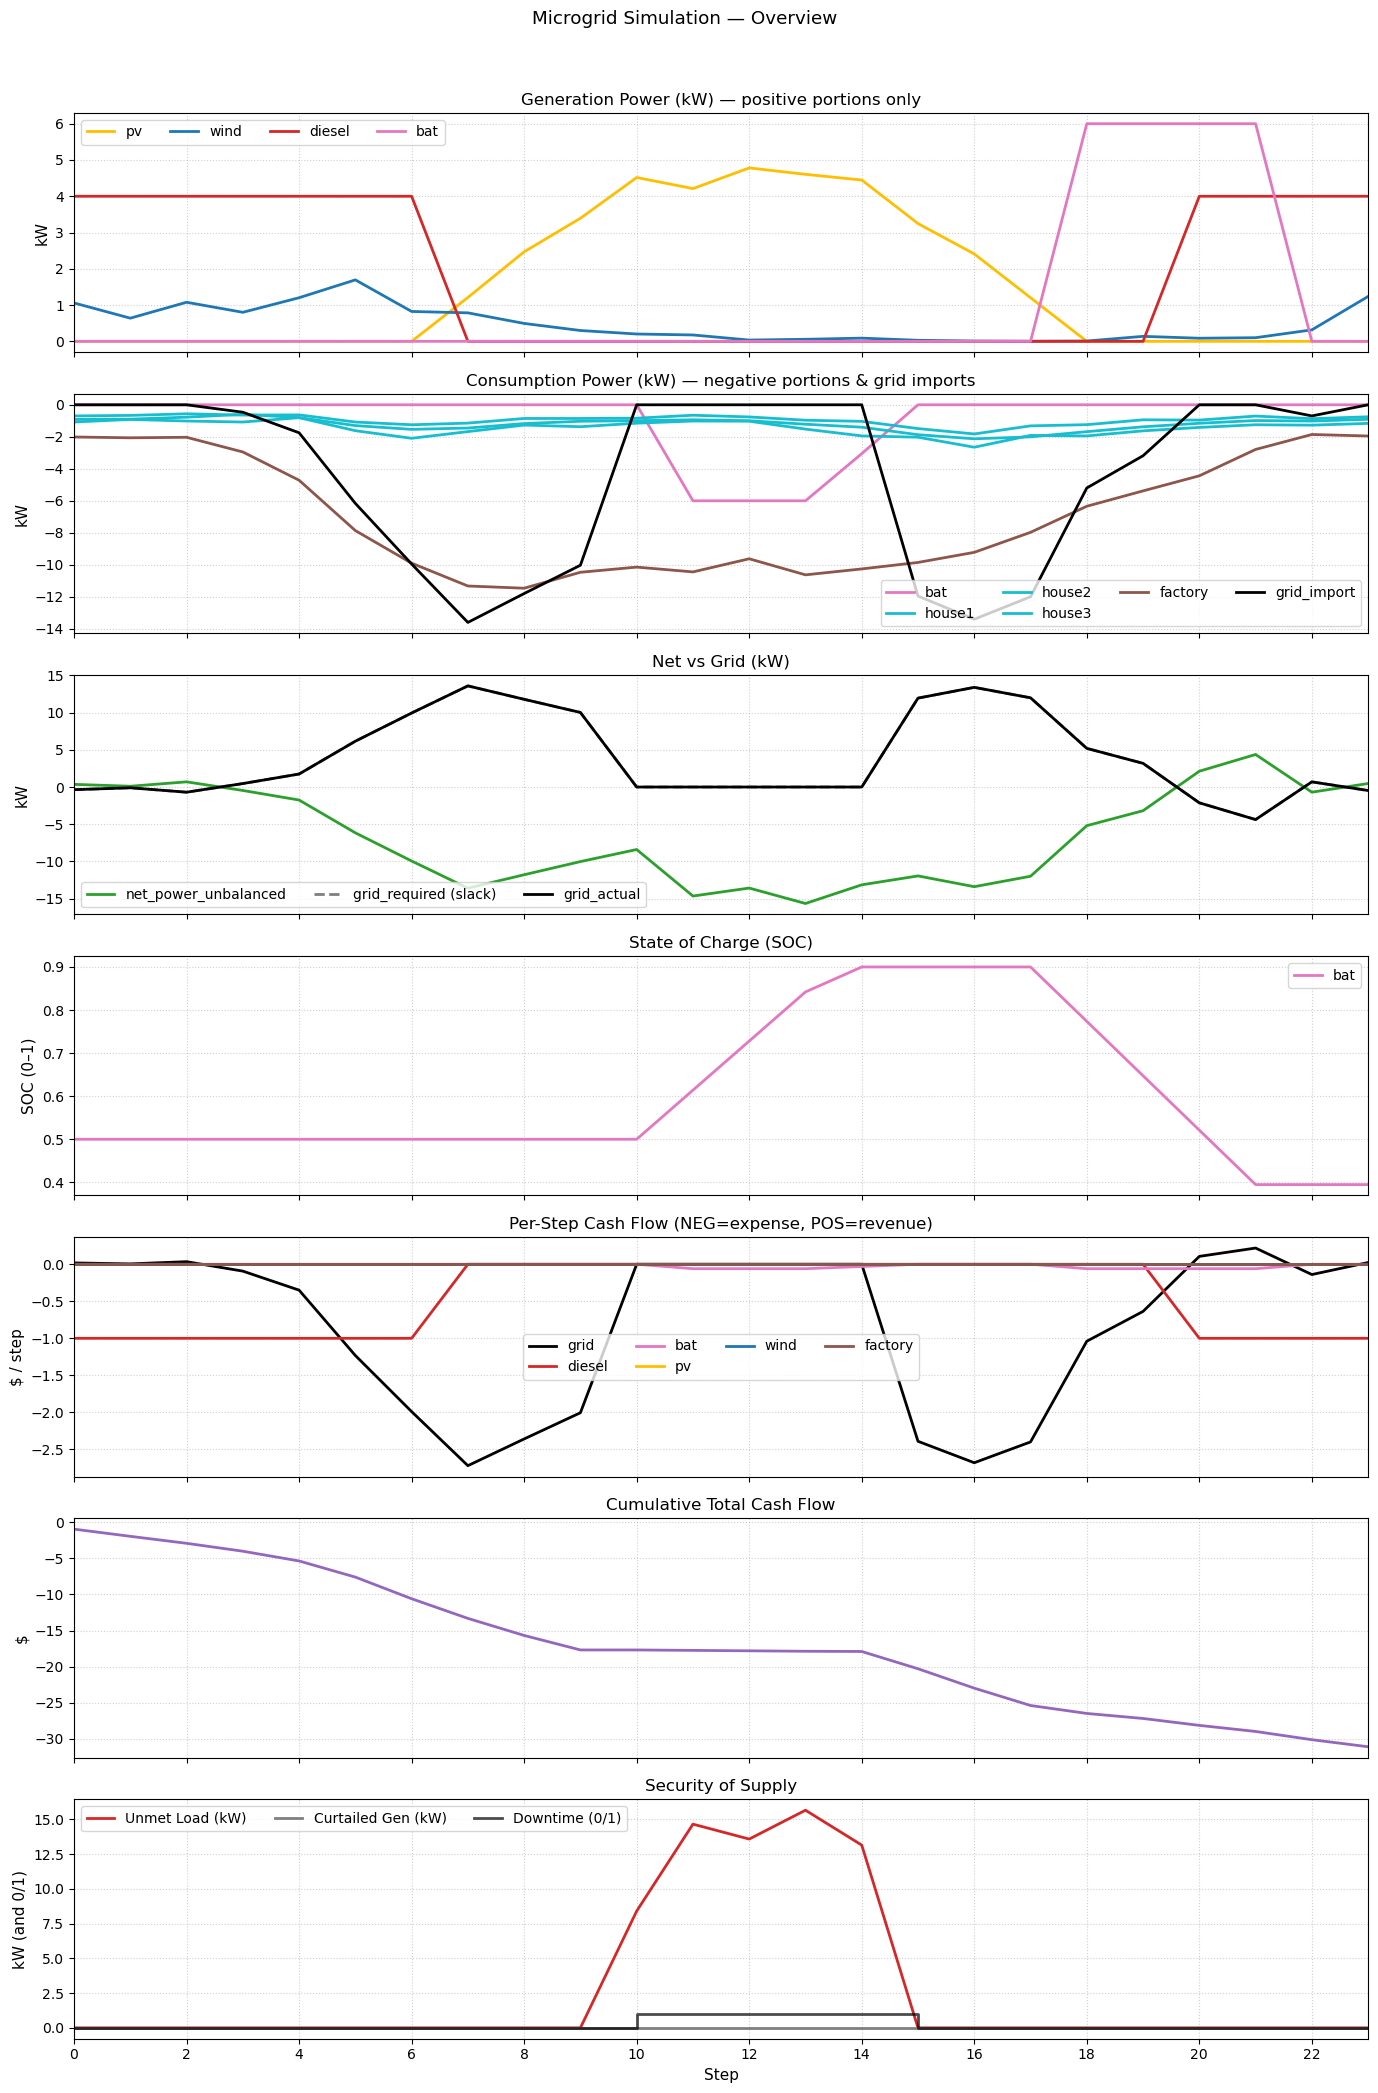

In [5]:
# --- 1. Build Environment ---
env2 = MicrogridEnv(simulation_steps=steps)

for c in (pv, wind, diesel, house1, house2, house3, factory, bat):
    env2.add_component(c)
env2.add_component(grid, is_grid=True)
env2.reset()

ems2 = RuleBasedEMS() # New EMS instance for this sim
island_start, island_end = 10, 15 # Island from 10:00 up to (but not incl.) 15:00

# --- 2. Run Online Simulation Loop ---
print(f"\nRunning Scenario 2: Midday Islanding (hours {island_start}-{island_end})...")
for k in range(steps):

    # --- DYNAMIC GRID CONTROL --- (This is the only change)
    if island_start <= k < island_end:
        grid.disconnect() # Tell the grid component to go offline
    else:
        grid.connect() # Reconnect
    # ---

    hour = k % 24
    soc = bat.get_soc() # bat state is evolving in this new sim
    current_exog = exog_list[k]
    actions = ems2.decide(hour=hour, soc=soc, exogenous=current_exog)

    env2.step(actions=actions, exogenous=current_exog)

# CRITICAL: Re-connect grid after sim in case it was left disconnected
grid.connect()

# --- 3. Get Results and Plot ---
df2 = env2.get_results()
_ = plot_simulation(df2, sim_name="03-02_rule_based_island", save=True)

# --- 4. Summary ---
total_cost_2 = df2["total_cashflow"].sum()
unmet_energy_2 = df2["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 2 Total Cost: ${total_cost_2:.2f}")
print(f"Scenario 2 Unmet Energy (kWh): {unmet_energy_2:.2f}")
df2.tail()

## Scenario 3 — Expensive Grid Imports


Running Scenario 3: Expensive Grid (Import=$0.5/kWh)...
Scenario 3 Total Cost: $-93.86
Scenario 3 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,wind_power,wind_cost,diesel_power,diesel_cost,grid_exp_power,grid_exp_cost,bat_power,bat_cost,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step,,,,,,,,,,,,,,,,,,,,,
19,0.0,0.0,0.137628,0.0,0.0,0.0,3.183139,-1.591570,6.0,-0.06,...,0.137628,-9.320768,6.0,3.183139,-3.183139,0.0,0.0,0.0,-1.651570,19.0
20,0.0,0.0,0.085780,0.0,4.0,-1.0,-2.124280,0.106214,6.0,-0.06,...,4.085780,-7.961500,6.0,-2.124280,2.124280,0.0,0.0,0.0,-0.953786,20.0
21,0.0,0.0,0.100270,0.0,4.0,-1.0,-4.375356,0.218768,6.0,-0.06,...,4.100270,-5.724914,6.0,-4.375356,4.375356,0.0,0.0,0.0,-0.841232,21.0
22,0.0,0.0,0.316426,0.0,4.0,-1.0,0.694583,-0.347292,0.0,-0.00,...,4.316426,-5.011010,0.0,0.694583,-0.694583,0.0,0.0,0.0,-1.347292,22.0
23,0.0,0.0,1.237430,0.0,4.0,-1.0,-0.470431,0.023522,0.0,-0.00,...,5.237430,-4.766999,0.0,-0.470431,0.470431,0.0,0.0,0.0,-0.976478,23.0


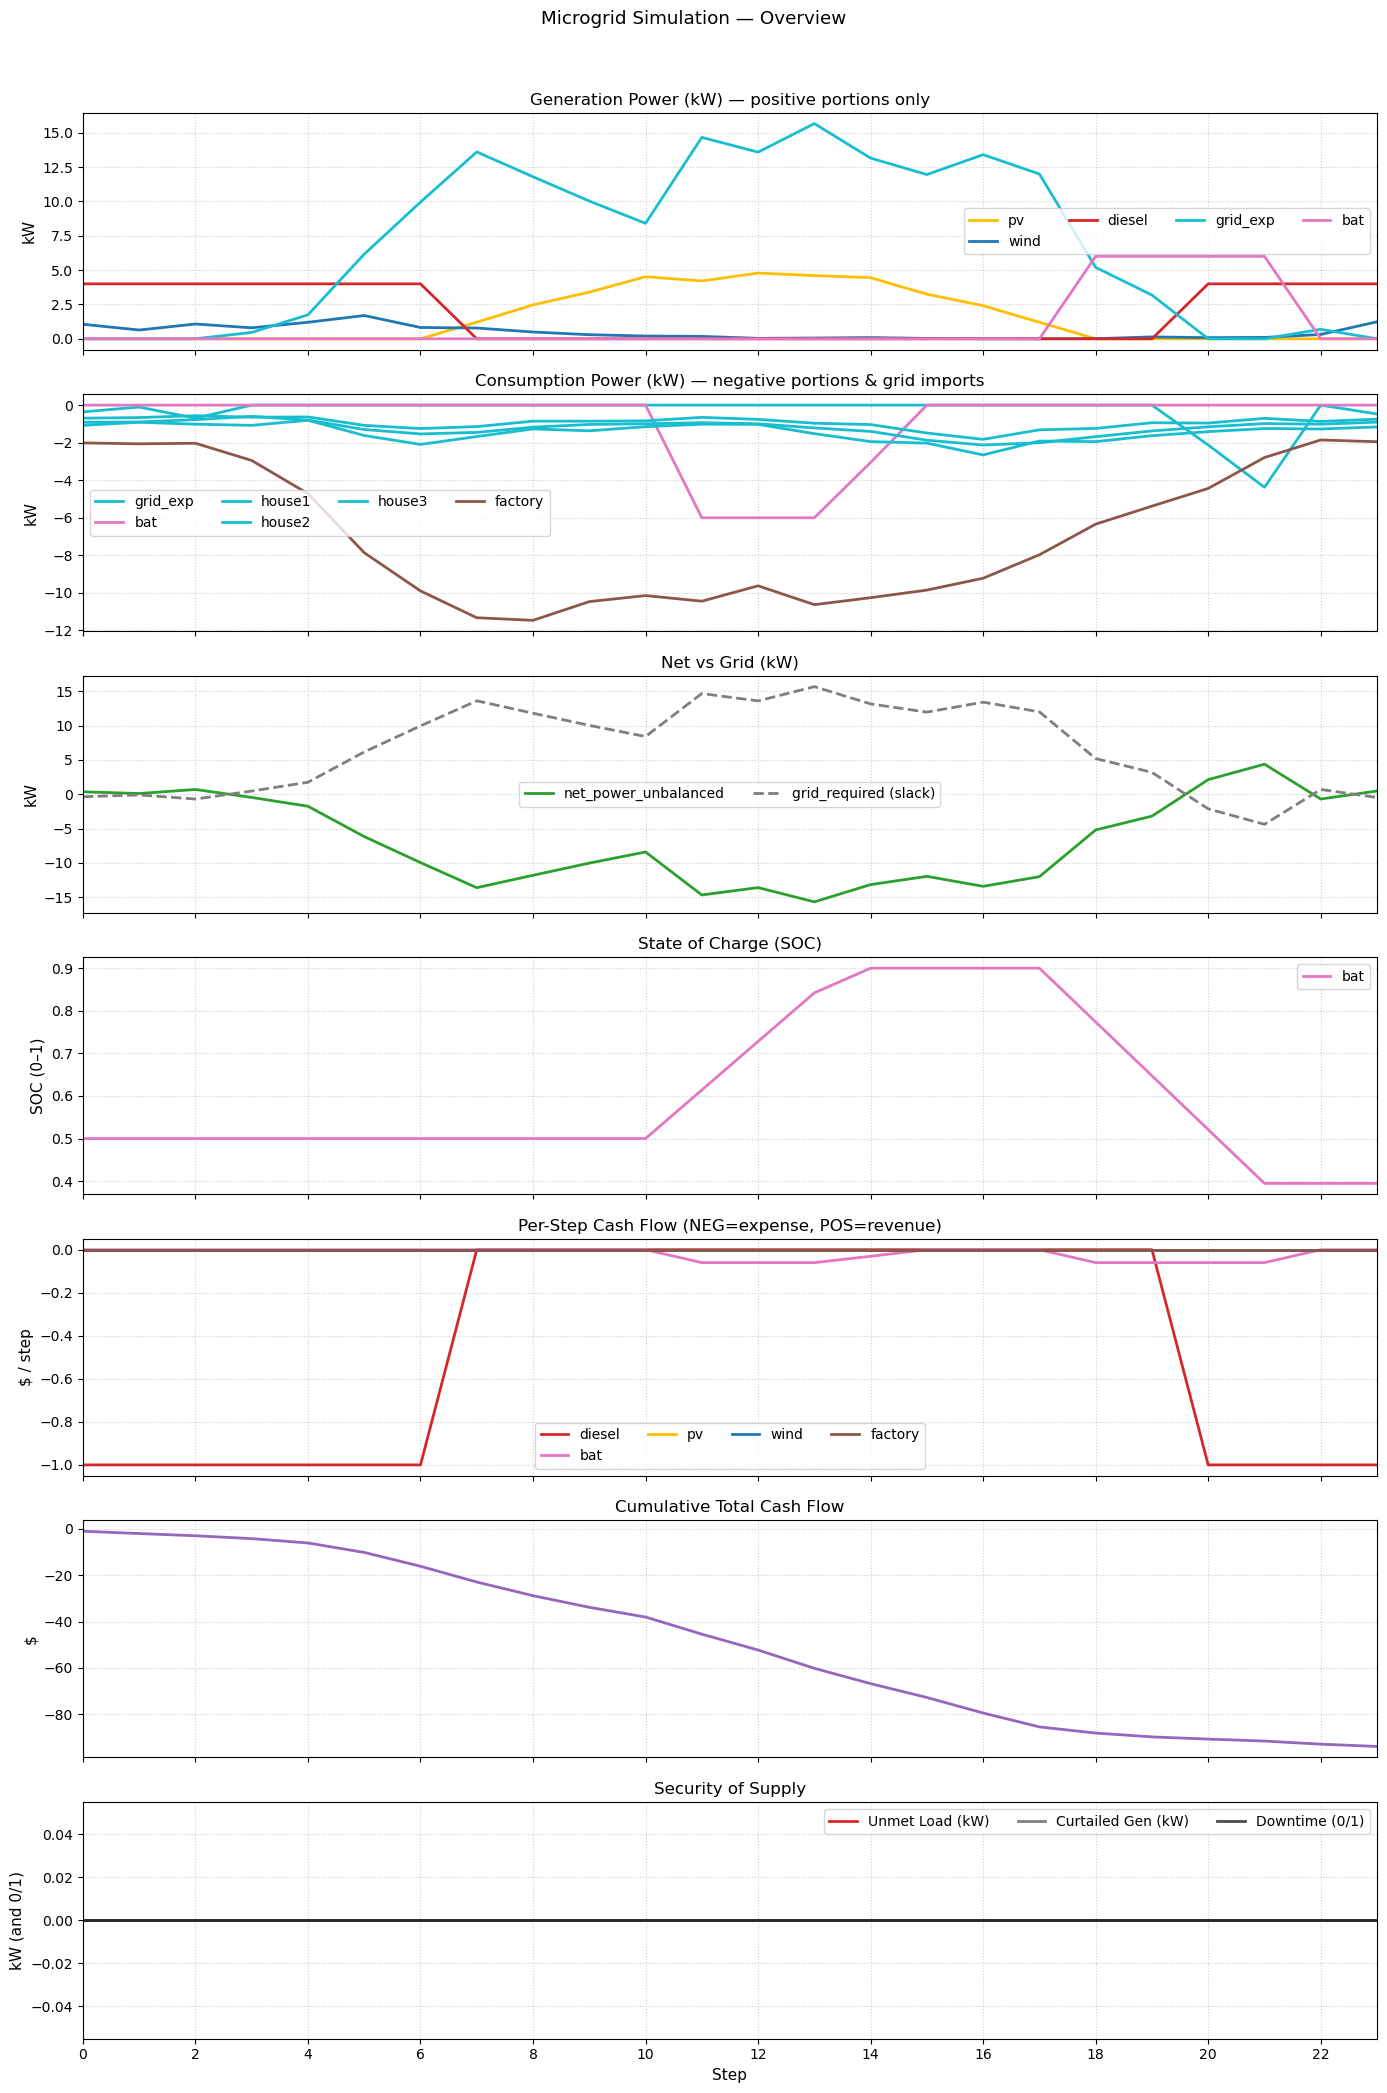

In [6]:
# --- 1. Define New Grid Component ---
grid_expensive = GridIntertie("grid_exp", time_step_minutes=dt,
                            price_import_per_kwh=0.50, # <-- 2.5x more expensive
                            price_export_per_kwh=0.05)

# --- 2. Build Environment ---
env3 = MicrogridEnv(simulation_steps=steps)
# Add all standard components
for c in (pv, wind, diesel, house1, house2, house3, factory, bat):
    env3.add_component(c)
# Add the NEW expensive grid
env3.add_component(grid_expensive, is_grid=True)
env3.reset()

ems3 = RuleBasedEMS()

# --- 3. Run Online Simulation Loop ---
print(f"\nRunning Scenario 3: Expensive Grid (Import=${grid_expensive.params.price_import_per_kwh}/kWh)...")
for k in range(steps):
    hour = k % 24
    soc = bat.get_soc() # state is evolving in env3
    current_exog = exog_list[k]
    actions = ems3.decide(hour=hour, soc=soc, exogenous=current_exog)

    env3.step(actions=actions, exogenous=current_exog)

# --- 4. Get Results and Plot ---
df3 = env3.get_results()
_ = plot_simulation(df3, sim_name="03-03_rule_based_expensive", save=True)

# --- 5. Summary ---
total_cost_3 = df3["total_cashflow"].sum()
unmet_energy_3 = df3["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 3 Total Cost: ${total_cost_3:.2f}")
print(f"Scenario 3 Unmet Energy (kWh): {unmet_energy_3:.2f}")
df3.tail()